# scoreCT: Automated cell type annotation in scRNA-seq data
ScoreCT is a script allowing automated annotation of scRNA-seq data analyzed with Scanpy. Providing your own reference or using the reference regularly updated and provided with the package, you can automatically assign clusters from your Scanpy analysis pipeline to cell types.


In [1]:
# Run this if you open in Colab
# !pip install scanpy

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LucasESBS/scoreCT/blob/master/example/tuto_scoreCT.ipynb)

## Requirements
### Clustering
scoreCT requires that your scanpy Anndata object contains a clustering field (*eg*: louvain, leiden), which will be used to assign cell types. See scanpy tutorial on how to run clustering on your data (typically running ```scanpy.tl.louvain(adata, args)```.
### Differential gene expression for cluster biomarkers
scoreCT will use the gene ranking from ```scanpy.tl.rank_genes_groups``` to assign cell types to cluster. This field has to be present in your Anndata object (in Anndata.uns). See scanpy tutorial and documentation on the details for this method.
### A reference containing cell types/markers
scoreCT is not relying on training data (as only a few datasets are consistently annotated at the time), but instead on a reference sheet for cell types and associated markers.

## The scoreCT model

scoreCT divides the top $K$ genes of each cluster ranked DE genes into $m$ bins and computed a weighted score $S$ for each cluster/cell type pair. A $p$-value is derived from 2 possible models:

* A __permutation test__, akin to enrichment tests (comparing $S$ to random scores)
* A __multinomial__ sum approximation

The multinomial sum approximation is very fast in comparison to the permutation test, but does not approximate the results well when the number of marker genes $n$ is too large compared to the total number of genes $N$. By default, scoreCT will run the multinomial sum approximation, but will automatically switch to the permutation test if $\frac{n}{N}> 0.01$ .

## Standard Usage: high-level API
Here, we use scoreCT high-level API. You just provide your (normalized) AnnData object, as well as the path to the marker gene file (For an example, you can look at the file __ref_marker.gmt__ used in this example). scoreCT will run all sub-routines internally and assign the results to the AnnData object. If differential gene expression was not run, scoreCT will run ```scanpy.tl.rank_genes_groups``` with default parameters to initialize cluster gene rankings. </br>

In [1]:
# Import modules
import os
import sys
import pandas as pd
import scanpy as sc
import scorect as ct
# Ignore warnings in this tutorial
import warnings
warnings.filterwarnings('ignore')

# Load example scRNA-seq data (already analyzed)
adata = sc.read('../data/week2_data_all.h5ad')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [3]:
# Use scoreCT one line API for assignments
ct.scorect(adata,
          marker_path='../data/ref_marker.gmt',
          K_top=300,
          m_bins=5,
          null_model='multinomial',
          cluster_key='louvain')

No differential test found in input AnnData object. Running Scanpy rank_gene_groups...
Using default values for differential test
Reading markers...
Wrangling: Number of markers used in ranked_gene_groups:  30044
Wrangling: Groups used for ranking: louvain
Scoring cell types in reference...
Assigning cell types in adata.obs['scoreCT']...


We can now visualize scoreCT assignments and compare with the true labels

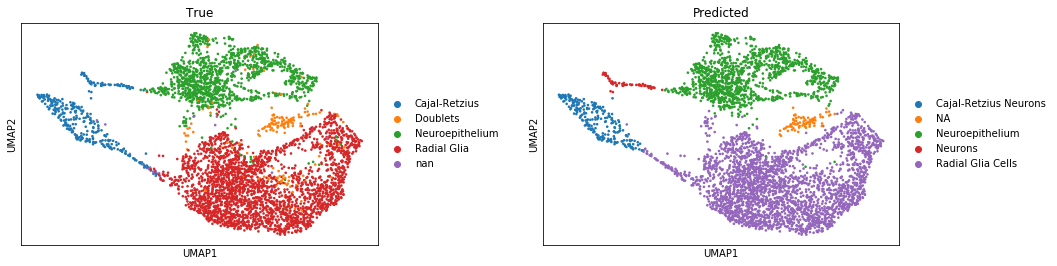

In [14]:
sc.pl.umap(adata, color=['cell_type', 'scoreCT'], title=['True','Predicted'], wspace=0.33)

## Non Standard Usage: using low-level API for custom rank files

The user can use the low-level API in case more control on each input function is wanted, or if custom rank files have to be loaded for clusters (cluster signatures, pre-computed DGE results...). </br>

Here, we just showcase the low-level API on the AnnData object, but the user can read its own rank files and input it to the rest of the scoreCT pipeline.

In [9]:
# Load reference table - scoreCT api provides a wrapper for gmt, tsv and csv formats.
ref_marker = ct.read_markers_from_file('../data/ref_marker.gmt')

In [6]:
# Run this if you didn't run scanpy rank_gene_groups() yet -- use raw slot of AnnData
sc.tl.rank_genes_groups(adata, groupby='louvain', n_genes=len(adata.raw.var), use_raw=True)

__Debugging__: Here, if an error is thrown, the raw slot of AnnData is probably empty. In this case (although not recommended), try to run:<br>
```python 
sc.tl.rank_genes_groups(adata, groupby='louvain', n_genes=len(adata.var), use_raw=False)```

In [7]:
# Wrangle results from existing sc.tl.rank_genes_groups() results
# Let's have a look for cluster 0
marker_df = ct.wrangle_ranks_from_anndata(adata)
print(marker_df.head())

Wrangling: Number of markers used in ranked_gene_groups:  30044
Wrangling: Groups used for ranking: louvain
     z_score      adj_pvals        gene cluster_number
0  68.056419   0.000000e+00       MGST1              0
1  55.290070   0.000000e+00        PRTG              0
2  49.419937  7.399108e-281       NR2F1              0
3  41.715881  3.992287e-229  AC018730.1              0
4  37.571159  9.347292e-197       SFRP2              0


Here, the ```marker_df``` variable can be loaded from a file if pre-computed by the user. scoreCT simply use 2 columns in the dataframe: ```gene```, storing the name of the genes (ordered by rank) and ```cluster_number```, storing the name of the cluster. Hence, this dataframe should have a length of ```(N_genes*n_clusters)```. </br>

*Note: The function ```ct.ranks_from_file``` can read a file formatted as ```(N_genes,n_clusters)``` into the appropriate format.*

In [11]:
# Score cell types for each cluster 
# Let's set parameters first - K represents the number of genes included in the ranking
# m represents the number of bins used to divide the top K genes.
K = 300
m = 5
# Get the background genes - here, all the genes used to run the differential gene expression test
background = adata.raw.var.index.tolist()
# Now run the function
ct_pval, ct_score = ct.celltype_scores(nb_bins=m,
                                        ranked_genes=marker_df,
                                        K_top = K,
                                        marker_ref=ref_marker,
                                        background_genes=background,
                                        null_model='multinomial')

__Help:__ The background genes correspond to all the gene used to run the differential test. If _raw_ was not used, use:
```python
background = adata.var.index.tolist()```

Let's assign results and visualize it on UMAP again

... storing 'scorect' as categorical


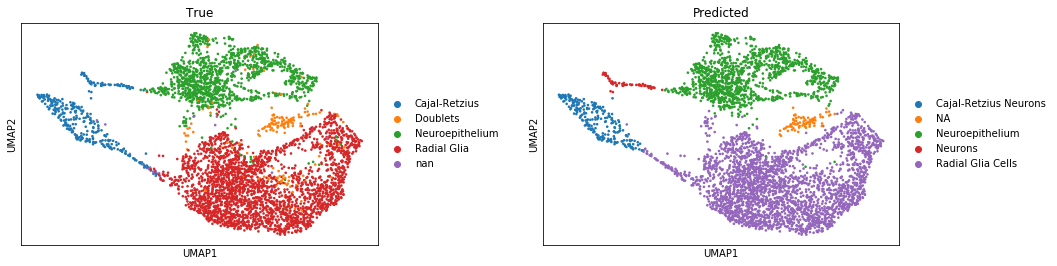

In [12]:
# Now assign clusters to cell types
cluster_assign = adata.obs['louvain']
celltype_assign = ct.assign_celltypes(cluster_assignment=cluster_assign, ct_pval_df=ct_pval, ct_score_df=ct_score, cutoff=0.1)
# Add to anndata object
adata.obs['scorect'] = celltype_assign
# Let's compare with the true assignment now! 
sc.pl.umap(adata, color=['cell_type','scorect'], title=['True','Predicted'], cmap='Set2', wspace=0.33)

We can also have a detail look at the model p-values for certain clusters

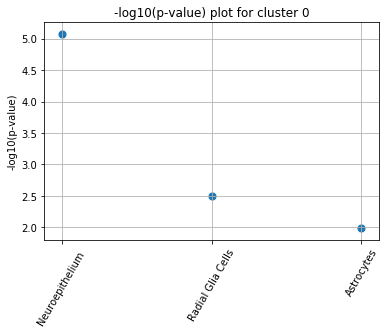

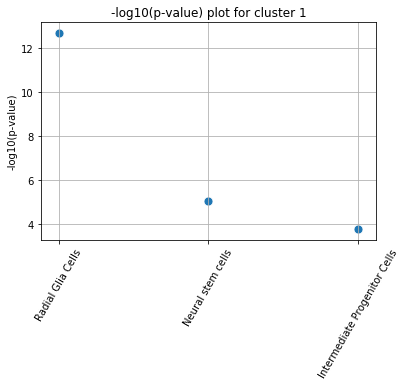

In [13]:
# Let's have a look at the pvalue for clusters 0 and 1
ct.plot_pvalue(ct_pval, clusters=['0','1'], n_types=3)